# Challenge

Now that you've learned about random forests and decision trees let's do an exercise in accuracy. You know that random forests are basically a collection of decision trees. But how do the accuracies of the two models compare?

So here's what you should do. Pick a dataset. It could be one you've worked with before or it could be a new one. Then build the best decision tree you can.

Now try to match that with the simplest random forest you can. For our purposes measure simplicity with runtime. 

Compare that to the runtime of the decision tree. This is imperfect but just go with it.

Hopefully out of this you'll see the power of random forests, but also their potential costs. Remember, in the real world you won't necessarily be dealing with thousands of rows. It could be millions, billions, or even more.

## Dataset

I will use lending data from 2007-2010 and be trying to classify and predict whether or not the borrower paid back their loan in full. Dataset can be downloaded from [here](https://www.lendingclub.com/info/download-data.action)

Columns:

* credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
* purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
* int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
* installment: The monthly installments owed by the borrower if the loan is funded.
* log.annual.inc: The natural log of the self-reported annual income of the borrower.
* dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
* fico: The FICO credit score of the borrower.
* days.with.cr.line: The number of days the borrower has had a credit line.
* revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
* revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
* inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
* delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
* pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import tree
from IPython.display import Image


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix

# Packages for rendering our tree.
import pydotplus


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Loading dataframe

loans = pd.read_csv('loan_data.csv')

In [3]:
#Verifying dataframe

loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
credit.policy        9578 non-null int64
purpose              9578 non-null object
int.rate             9578 non-null float64
installment          9578 non-null float64
log.annual.inc       9578 non-null float64
dti                  9578 non-null float64
fico                 9578 non-null int64
days.with.cr.line    9578 non-null float64
revol.bal            9578 non-null int64
revol.util           9578 non-null float64
inq.last.6mths       9578 non-null int64
delinq.2yrs          9578 non-null int64
pub.rec              9578 non-null int64
not.fully.paid       9578 non-null int64
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [4]:
loans.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


## Exploratory Data Analysis


Text(0.5,0,'FICO')

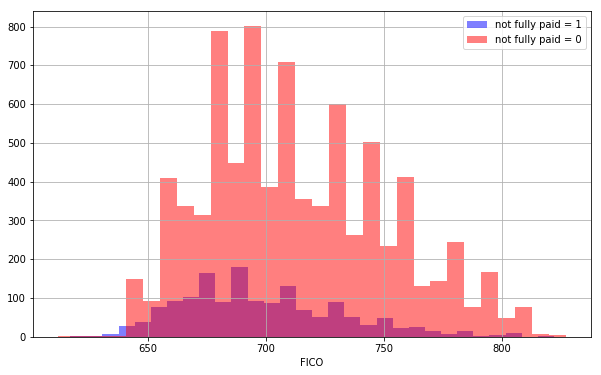

In [5]:
#FICO distributions, grouped by our target not.fully.paid

plt.figure(figsize=(10,6))

loans[loans['not.fully.paid']==1]['fico'].hist(alpha=0.5,color='blue',label='not fully paid = 1',bins=30)
loans[loans['not.fully.paid']==0]['fico'].hist(alpha=0.5,color='red',label='not fully paid = 0',bins=30)

plt.legend()
plt.xlabel('FICO')

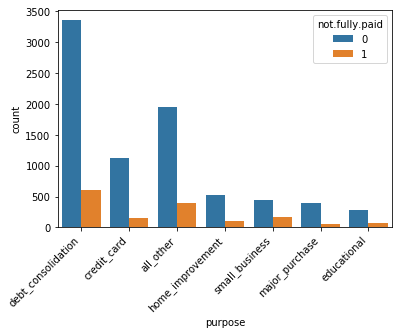

In [6]:
#Bar visualizations for purpose feature grouped by our target feature

sns.countplot(loans['purpose'], hue=loans['not.fully.paid'])
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()


In [7]:
#Verifying if there are null values or not

loans.isnull().sum()

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

## Setting up the Data

In [8]:
#creating a list with categorical variables
cat_feats = ['purpose']

#Getting dummies and creating a new dataframe
final_data = pd.get_dummies(loans,columns=cat_feats,drop_first=True) 

In [9]:
final_data.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


In [10]:
#Setting X and y

X = final_data.drop('not.fully.paid', axis=1)
y = final_data['not.fully.paid']

#Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

## Creating a Decision Tree

In [11]:
#Create an instance of DecisionTreeClassifier() 

start_time = time.time()

decision_tree = DecisionTreeClassifier(criterion='entropy', max_features=1, max_depth=4)

#Fit the model
decision_tree.fit(X_train, y_train)

#Making predictions
predictions = decision_tree.predict(X_test)

print("--- Runtime: %s seconds ---" % (time.time() - start_time))

--- Runtime: 0.004687786102294922 seconds ---


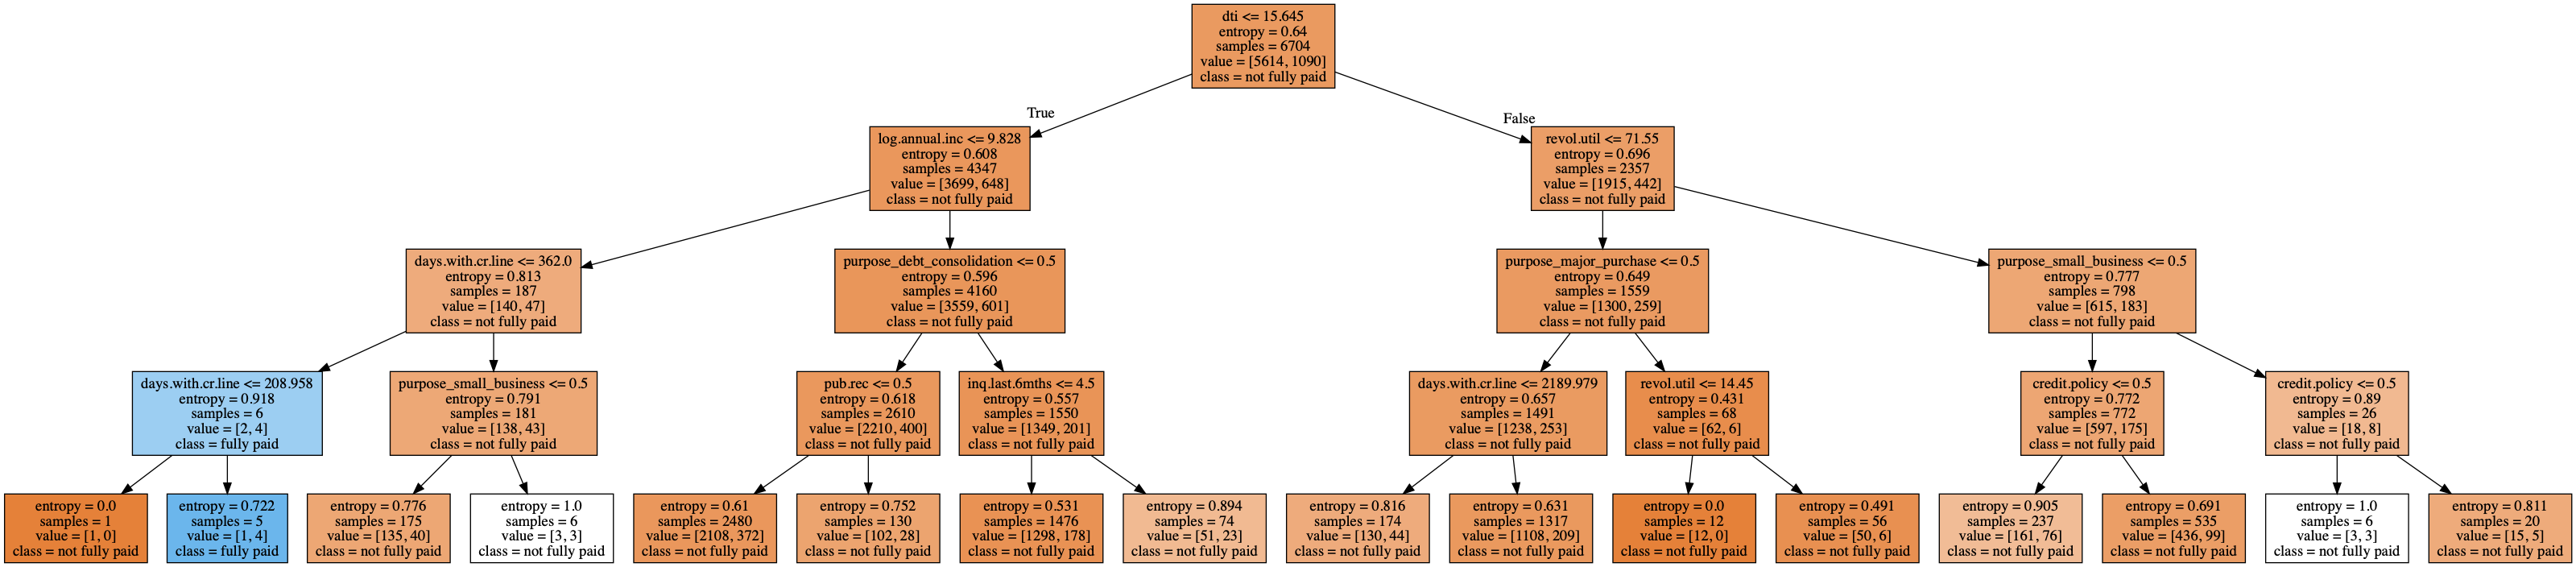

In [12]:
# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['not fully paid', 'fully paid'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [13]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.85      1.00      0.92      2431
          1       0.67      0.00      0.01       443

avg / total       0.82      0.85      0.78      2874



In [14]:
print(confusion_matrix(y_test,predictions))

[[2430    1]
 [ 441    2]]


## Creating Random Forest model


In [15]:
#Setting start time to calculate runtime
start_time = time.time()

#Creating an instance of the RandomForestClassifier class
rfc = ensemble.RandomForestClassifier()

#If we add parameter n_estimators, runtime increases
#rfc = ensemble.RandomForestClassifier(n_estimators=50)

#Fitting the model
rfc.fit(X_train,y_train)

#Making predictions
predictionsrfc = rfc.predict(X_test)

print("--- Runtime: %s seconds ---" % (time.time() - start_time))

--- Runtime: 0.1068868637084961 seconds ---


**Classification Report**

In [16]:
print(classification_report(y_test,predictionsrfc))

             precision    recall  f1-score   support

          0       0.85      0.98      0.91      2431
          1       0.27      0.04      0.07       443

avg / total       0.76      0.83      0.78      2874



**Confusion Matrix**

In [17]:
confusion_matrix(y_test,predictionsrfc)

array([[2379,   52],
       [ 424,   19]])

## Conclusions:

- Based on runtime, _**Decision Tree**_ was faster than Random Forest. In the case of Random Forest, if I included n_estimators as a parameter, the runtime increases even more.

- Based on precision, recall(sensitivity) and f1-score, _**Random Forest**_ got better metrics than Desicion Tree.

___
By: Wendy Navarrete

08/23/2019